In [1]:
%matplotlib inline
import daft
import pymc
import matplotlib.pyplot as plt
import matplotlib as mlp
import numpy as np
import ggplot
import pandas as pd

COLORS = ["#348ABD", "#A60628", "#7A68A6"]

Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 30 days


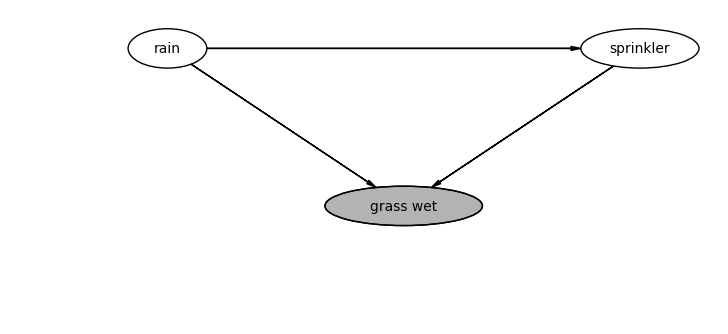

In [3]:
pgm = daft.PGM([9, 4], origin=[1, 0.5])
pgm.add_node(daft.Node('r', 'rain', 3, 4, aspect=2))
pgm.add_node(daft.Node('s', 'sprinkler', 9, 4, aspect=3))
pgm.add_node(daft.Node('w', 'grass wet', 6, 2, aspect=4, observed=True))
pgm.add_edge('r', 's')
pgm.add_edge('r', 'w')
pgm.add_edge('s', 'w')
pgm.render()

In [5]:
from IPython.display import Image
Image(url='http://upload.wikimedia.org/wikipedia/commons/0/0e/SimpleBayesNet.svg')

In [6]:
# Initialization
observed_values = [1.]

rain = pymc.Bernoulli('rain', .2, value=np.ones(len(observed_values)))

p_sprinkler = pymc.Lambda('p_sprinkler', lambda rain=rain: np.where(rain, .01, .4))

# "Real" sprinkler varible
sprinkler = pymc.Bernoulli('sprinkler', p_sprinkler, value=np.ones(len(observed_values)))

p_grass_wet = pymc.Lambda('p_grass_wet', lambda sprinkler=sprinkler, rain=rain: np.where(sprinkler, np.where(rain, .99, .9), 
                                                                                         np.where(rain, .8, 0.2)))
grass_wet = pymc.Bernoulli('grass_wet', p_grass_wet, value=observed_values, observed=True)

model = pymc.Model([grass_wet, p_grass_wet, sprinkler, p_sprinkler, rain])

In [7]:
## Inference
mcmc = pymc.MCMC(model)
mcmc.sample(10000, 2000)

 [-----------------100%-----------------] 10000 of 10000 complete in 1.5 sec

In [8]:
trace_r = mcmc.trace('rain')[:]
trace_p_sprinkler = mcmc.trace('p_sprinkler')[:]
trace_sprinkler = mcmc.trace('sprinkler')[:]
trace_p_grass_wet = mcmc.trace('p_grass_wet')[:]

Plotting sprinkler_0
Plotting p_sprinkler_0
Plotting p_grass_wet_0
Plotting rain_0


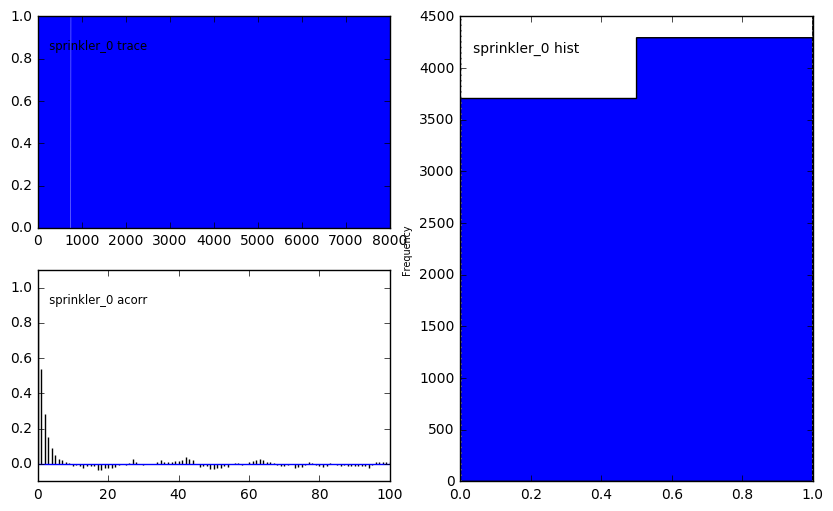

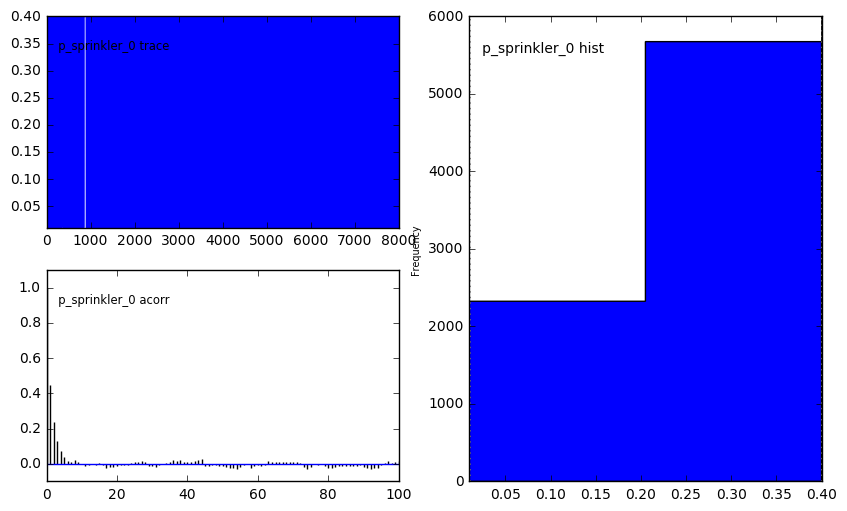

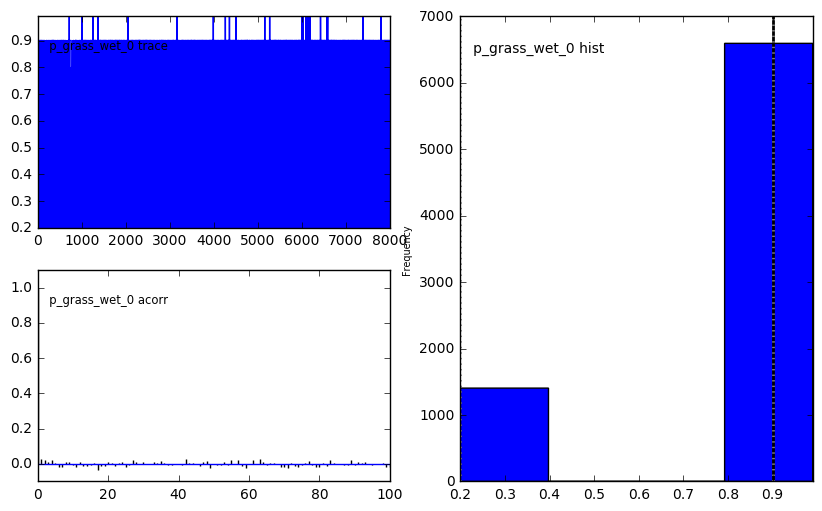

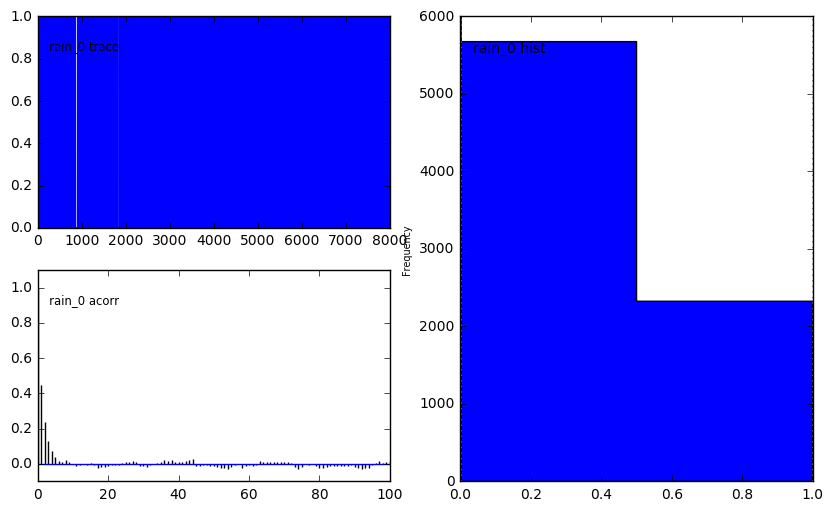

In [9]:
# Convergence diagnostic
pymc.Matplot.plot(mcmc)

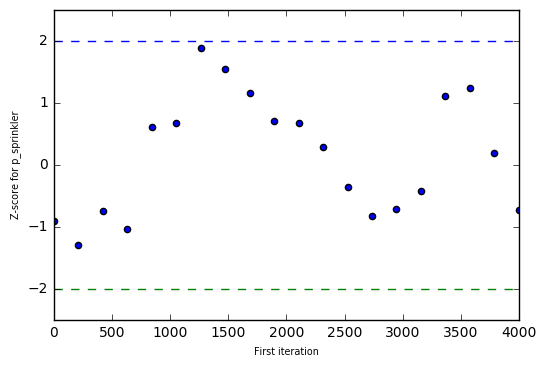

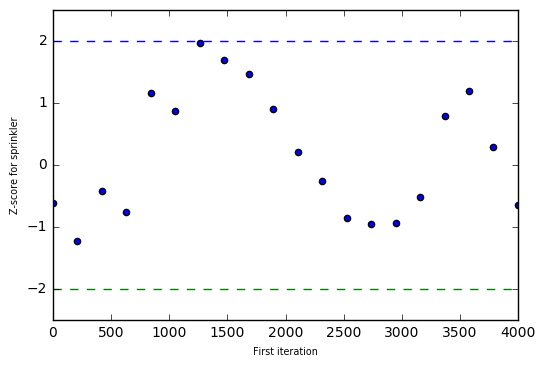

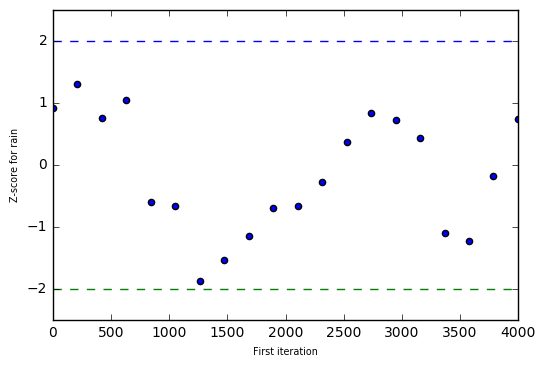

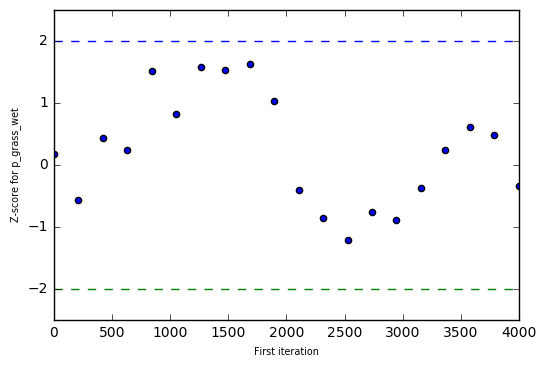

In [10]:
geweke = pymc.geweke(mcmc)
pymc.Matplot.geweke_plot(geweke)

In [11]:
dictionary = {
              'Rain': [1 if ii[0] else 0 for ii in trace_r.tolist() ],
              'Sprinkler': [1 if ii[0] else 0 for ii in trace_sprinkler.tolist() ],
              'Sprinkler Probability': [ii[0] for ii in trace_p_sprinkler.tolist()],
              'Grass Wet': [ii[0] for ii in trace_p_grass_wet.tolist()],
              }
df = pd.DataFrame(dictionary)
df.head()

,Grass Wet,Rain,Sprinkler,Sprinkler Probability
0,0.8,1,0,0.01
1,0.2,0,0,0.40
2,0.9,0,1,0.40
3,0.9,0,1,0.40
4,0.9,0,1,0.40


In [12]:
# Given grass is wet, what is the probability that it was rained?
p_rain_wet = float(df[(df['Rain'] == 1) & (df['Grass Wet'] > 0.5)].shape[0]) / df[df['Grass Wet'] > 0.5].shape[0] 
print(p_rain_wet)

0.352539802881


In [13]:
# Given grass is wet, what is the probability that sprinkler was opened?
p_sprinkler_wet = float(df[df['Sprinkler'] == 1].shape[0]) / df[df['Grass Wet'] > 0.5].shape[0] 
print(p_sprinkler_wet)

0.651099317665


In [14]:
# Case where sprinkler did not work and it did not rain
p_not_sprinkler_rain_wet = float(df[(df['Sprinkler'] == 0) & (df['Rain'] == 0)].shape[0]) / df[df['Grass Wet'] > 0.5].shape[0] 
print(p_not_sprinkler_rain_wet)


0.213040181956
